In [11]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import timm
import detectors

import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn 
import numpy
from tqdm import tqdm
from ffcv.writer import DatasetWriter
from ffcv.fields import BytesField, IntField, RGBImageField

from data_utils.data_stats import *
from models.networks import get_model
from data_utils.dataloader import get_loader
from data_utils.dataset_to_beton import get_dataset
from data_utils import texture_shape_transformations as ts
from utils.metrics import topk_acc, real_acc, AverageMeter

In [20]:
def get_data_and_model(dataset, model, dataset_type, data_path='C:\\Users\\Leonidas\\OneDrive\\Desktop\\zooming_in_on_mlps\\beton', split='test', batch_size=100):
    """
    This function retrieves the data, model and feature extractor (if needed) based on the provided information.

    Parameters:
    dataset (str): The name of the dataset to retrieve (can be cifar10, cifar100 or imagenet).
    model (str): The name of the model to retrieve (can be mlp, cnn or vit; only mlp is supported for dataset imagenet).
    data_path (str): The path to the data.

    Returns (as a tuple):
    data_loader (DataLoader): The retrieved data loader.
    model (Model): The retrieved model.

    Raises:
    AssertionError: If the dataset or model is not supported.
    """

    assert dataset in ('cifar10', 'cifar100', 'imagenet'), f'dataset {dataset} is currently not supported by this function'
    assert model in ('mlp', 'cnn', 'vit'), f'model {model} is currently not supported by this function'

    num_classes = CLASS_DICT[dataset]
    eval_batch_size = batch_size
 
    if dataset == 'imagenet':
        data_resolution = 64
        assert model == 'mlp', f'imagenet dataset is only supported by mlp model'
    else:
        data_resolution = 32

    crop_resolution = data_resolution

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    if device == 'cuda':
        torch.backends.cuda.matmul.allow_tf32 = True

    if model == 'mlp':
        architecture = 'B_12-Wi_1024'
        checkpoint = 'in21k_' + dataset
        model = get_model(architecture=architecture, resolution=64, num_classes=num_classes, checkpoint=checkpoint)

    if model == 'cnn':
        architecture = 'resnet18_' + dataset
        model = timm.create_model(architecture, pretrained=True)

    if model == 'vit':
        architecture = 'vit_small_patch16_224_' + dataset + '_v7.pth'
        model = torch.load(architecture)
        
    if (dataset_type=='stylized') == False : 
        data_loader = ts.get_Shapeloader(
            dataset   = dataset,
            bs        = eval_batch_size,
            mode      = split,
            augment=split == 'train',
            dev       = device,
            mixup     = 0.0,
            data_path = data_path,
            data_resolution = data_resolution,
            crop_resolution = crop_resolution,
            dataset_type    = dataset_type
            )
    
    if dataset_type == 'stylized':
        transform = transforms.Compose([
            transforms.Resize((crop_resolution, crop_resolution)),  
            transforms.ToTensor(),])

        stylized_dataset = ts.StylizedDataset('C:\\Users\\Leonidas\\OneDrive\\Desktop\\zooming_in_on_mlps\\stylized_datasets\\cifar10_None', transform=transform)

        data_loader = ts.DataLoader(stylized_dataset, batch_size=eval_batch_size, shuffle=True)
        

    return data_loader, model

In [13]:
class Reshape(torch.nn.Module): 
    def __init__(self, shape=224): 
        super(Reshape, self).__init__()
        self.shape = shape 
        
    def forward(self, x): 
        shape = self.shape
        x = transforms.functional.resize(x, size=(shape, shape))
        if shape == 64:
            bs = x.shape[0]
            x = torch.reshape(x, shape=(bs,-1,))
        return x

In [ ]:
dataset_name = 'cifar10'
model_name = 'mlp'
dataset_type = 'grayscale'

loader, model = get_data_and_model(dataset=dataset_name, model=model_name, dataset_type=dataset_type, data_path='C:\\Users\\Leonidas\\OneDrive\\Desktop\\zooming_in_on_mlps\\beton', split='test', batch_size=512)

if model_name == 'mlp':
    model = nn.Sequential(Reshape(64), model)

if model_name == 'vit':
    model = nn.Sequential(Reshape(224), model)


In [ ]:
# image viewing
import matplotlib.pyplot as plt

with torch.no_grad():
    dataiter    = iter(loader)
    ims, labels = next(dataiter)
    img_to_show = ims[225]
    print(ims.shape, labels.shape)
    
    if not isinstance(img_to_show, np.ndarray):
        img_to_show = img_to_show.numpy()
    
    print(img_to_show.shape)
    # for shuffled images need to add .astype(np.uint8)
    plt.imshow(img_to_show.T)

In [14]:
# Defines a test function that evaluates the test accuracy of the loaded model/transformation 
# for every class of cifar10 .

@torch.no_grad()    
def test_class_n(model, loader,n):
    model.eval()
    class_n_acc = AverageMeter()
    
    

    for ims, targs in tqdm(loader, desc="Evaluation"):
        
        preds = model(ims)
        
        targs_new_list = []
        preds_new_list = []
        
        for i in range(len(targs)) :
            if targs[i] == n:
                targs_new_list.append(targs[i])
                preds_new_list.append(preds[i])
                
        if not targs_new_list:
            continue 
                
        targs_new = torch.stack(targs_new_list)
        preds_new = torch.stack(preds_new_list)        
        
        acc = real_acc(preds_new, targs_new, k=5, avg=True)
        class_n_acc.update(acc, ims.shape[0]) 
        
           
    return (
        class_n_acc.get_avg(percentage=True),
        
    )

In [10]:
tuple_1 = test_class_n(model, loader, n=0)
tuple_2 = test_class_n(model, loader, n=1)
tuple_3 = test_class_n(model, loader, n=2)
tuple_4 = test_class_n(model, loader, n=3)
tuple_5 = test_class_n(model, loader, n=4)
tuple_6 = test_class_n(model, loader, n=5)
tuple_7 = test_class_n(model, loader, n=6)
tuple_8 = test_class_n(model, loader, n=7)
tuple_9 = test_class_n(model, loader, n=8)
tuple_10 = test_class_n(model, loader, n=9)


test_class_1_acc = np.array(tuple_1[0].item()) 
test_class_2_acc = np.array(tuple_2[0].item())
test_class_3_acc = np.array(tuple_3[0].item())
test_class_4_acc = np.array(tuple_4[0].item())
test_class_5_acc = np.array(tuple_5[0].item())
test_class_6_acc = np.array(tuple_6[0].item()) 
test_class_7_acc = np.array(tuple_7[0].item())
test_class_8_acc = np.array(tuple_8[0].item())
test_class_9_acc = np.array(tuple_9[0].item())
test_class_10_acc = np.array(tuple_10[0].item())

test_all_classes_acc = np.array([test_class_1_acc, test_class_2_acc, test_class_3_acc, test_class_4_acc, test_class_5_acc, test_class_6_acc, test_class_7_acc, test_class_8_acc, test_class_9_acc, test_class_10_acc])

print(test_all_classes_acc)

Evaluation:  40%|████      | 8/20 [00:08<00:12,  1.08s/it]


KeyboardInterrupt: 

In [1]:
import numpy as np

acc_B_12_Wi_1024_grayscale = np.array( [90.60163116, 86.58802032, 71.03863525, 82.86347198, 85.42298126, 59.4724617,
 78.10970306, 87.77689362, 89.53246307, 86.39989471] )

acc_Vit_grayscale = np.array([88.71141815, 78.76961517, 78.72644043, 82.62313843, 56.64732361, 63.65930176,
 86.56697845, 88.33841705, 90.11930847, 92.89593506])

acc_CNN_grayscale = np.array([90.61014557, 93.86965942, 80.90284729, 90.144104,   82.69236755, 81.28423309,
 88.97644806, 89.74946594, 94.26036072, 93.65608978])

acc_B_12_Wi_1024_occluded = np.array([62.62025452, 18.02142715, 39.26353836, 66.94885254, 54.81447983, 38.47133255,
 34.01692963, 43.2136879,  46.14099503, 86.99600983])

acc_Vit_occluded = np.array([73.3727951,  46.33624268, 68.18949127, 72.34455872, 71.52188873, 56.89443588,
 65.12810516, 74.4233551,  72.77259064, 90.13330078])

acc_CNN_occluded = np.array([55.28726959, 37.82196426, 27.41372108, 37.90256119, 19.68580627, 21.96700096,
  9.89237499, 25.03257751, 54.73659515, 78.98101044])

acc_B_12_Wi_1024_shuffled = np.array([42.78529358,  8.43040085, 27.42309761, 61.9797821,  39.41212845, 19.15467072,
 24.63440704,  9.54283428, 13.25744343, 64.33995056])

acc_Vit_shuffled = np.array([61.06734848, 39.21717453, 58.58289337, 76.94311523, 36.9121933,  16.78746414,
 53.30687332, 50.89263916, 37.50557327, 84.60777283])

acc_CNN_shuffled = np.array([49.53892136,  6.10336494, 16.64393044, 31.72009468, 34.00931168,  7.60824776,
 14.88562965, 17.25509071, 43.15248489, 87.3731308 ])

acc_B_12_Wi_1024_edged = np.array([33.13269424,  1.76605415, 20.59712219, 57.07995605,  9.82701015,  3.84182692,
 57.98770142, 27.85633087, 18.47223473, 23.39993477])

acc_Vit_edged = np.array([15.29953861,  2.16743994, 76.87985992, 36.87343597,  5.37955189,  6.39922523,
  5.25006056, 10.56084728, 69.62446594,  4.98120117])

acc_CNN_edged = np.array([51.38577652, 37.54698944, 27.07089043, 87.02065277, 34.97031403, 32.18006897,
 25.10679817, 46.36006165, 46.44708252, 22.46714211])

acc_B_12_Wi_1024_stylized = np.array([42.35424805,  4.62544441, 33.88447952, 81.73014069, 44.40874863, 18.18210411,
 18.58835411, 35.54258347, 45.92625809, 45.1654892 ])

acc_CNN_stylized = np.array([ 9.97588062,  0.22400002,  2.05261755, 77.90389252,  2.09117484, 41.80592346,
  5.49640369,  6.81733847, 38.77479553,  0.87649888])

acc_Vit_stylized = np.array([40.43080902,  4.56661367, 29.20985031, 53.48271942, 58.1090126,  32.15496063,
 27.77684593, 28.61413765, 65.32761383, 28.3950367 ])


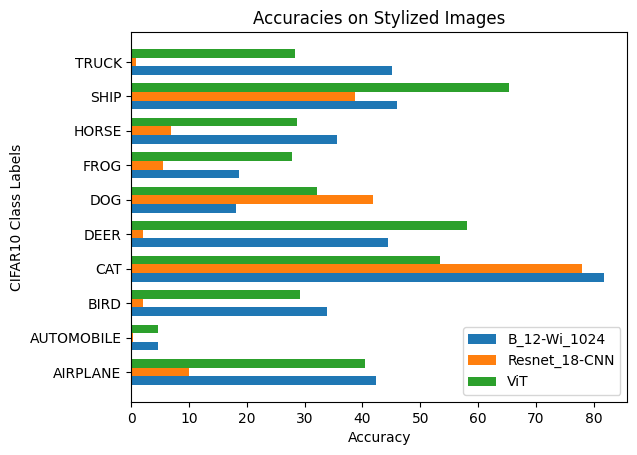

In [2]:
#plots the class accuracies for the 3 models tested on modified images of cifar10 

import numpy as np
import matplotlib.pyplot as plt


acc_model1 = acc_B_12_Wi_1024_stylized
acc_model2 = acc_CNN_stylized
acc_model3 = acc_Vit_stylized
class_labels = ['AIRPLANE', 'AUTOMOBILE', 'BIRD', 'CAT', 'DEER', 'DOG', 'FROG', 'HORSE', 'SHIP', 'TRUCK']

bar_width = 0.25
index = np.arange(len(class_labels))

plt.barh(index, acc_model1, height=bar_width, label='B_12-Wi_1024')
plt.barh(index + bar_width, acc_model2, height=bar_width, label='Resnet_18-CNN')
plt.barh(index + 2 * bar_width, acc_model3, height=bar_width, label='ViT')

plt.yticks(index + bar_width, class_labels)
plt.xlabel('Accuracy')
plt.ylabel('CIFAR10 Class Labels')
plt.title('Accuracies on Stylized Images')
plt.legend()

plt.show()
 

